In [248]:
from extract_data import export_data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler

# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
# import optuna
# import xgboost as xgb
# from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-darkgrid')

In [249]:
file = "database.sqlite"
data = export_data(file)

(90400, 81)
  row_names game.id  game.type  \
0         1       1  boardgame   
1         2       2  boardgame   
2         3       3  boardgame   
3         4       4  boardgame   
4         5       5  boardgame   

                                 details.description  \
0  Die Macher is a game about seven sequential po...   
1  Dragonmaster is a trick-taking card game based...   
2  Part of the Knizia tile-laying trilogy, Samura...   
3  When you see the triangular box and the luxuri...   
4  In Acquire, each player strategically invests ...   

                                  details.image  details.maxplayers  \
0   //cf.geekdo-images.com/images/pic159509.jpg                 5.0   
1   //cf.geekdo-images.com/images/pic184174.jpg                 4.0   
2  //cf.geekdo-images.com/images/pic3211873.jpg                 4.0   
3   //cf.geekdo-images.com/images/pic285299.jpg                 4.0   
4   //cf.geekdo-images.com/images/pic342163.jpg                 6.0   

   details.maxplayt

In [250]:
#keep columns that have at least 80% non-null values
data.dropna(thresh=int(len(data)*0.8), axis=1, inplace=True)

In [251]:
#dropping id columns and images/descriptions since we will not use them, also there are columns the quality for which is questionable, we will drop them too
redundant_columns = ['row_names', 'game.id', 'details.image', 'details.thumbnail', 'details.description', 
                     'stats.median', 'stats.wanting', 'stats.wishing', 'stats.numcomments', 'stats.numweights', 'stats.stddev', 'stats.trading',
                     'details.maxplaytime', 'details.minplaytime', 'details.playingtime']
data.drop(redundant_columns, axis=1, inplace=True)

In [252]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   game.type                      90400 non-null  object 
 1   details.maxplayers             90397 non-null  float64
 2   details.minage                 90397 non-null  float64
 3   details.minplayers             90397 non-null  float64
 4   details.name                   90400 non-null  object 
 5   details.yearpublished          90397 non-null  float64
 6   attributes.boardgamecategory   88869 non-null  object 
 7   attributes.boardgamedesigner   78517 non-null  object 
 8   attributes.boardgamemechanic   75163 non-null  object 
 9   attributes.boardgamepublisher  90305 non-null  object 
 10  attributes.total               90400 non-null  float64
 11  stats.average                  90400 non-null  float64
 12  stats.averageweight            90400 non-null 

In [253]:
#get rid of the expansions
data = data[data['game.type'] == 'boardgame']
data = data.drop('game.type', axis=1)

In [254]:
#keep games that with a known publisher and release year
#also, we will not use the publisher/designer info in the analysis, so drop them
data.dropna(subset=['attributes.boardgamepublisher', 'details.yearpublished'], axis=0, inplace=True)
data.drop(['attributes.boardgamepublisher', 'attributes.boardgamedesigner'], axis=1, inplace=True)

In [255]:
#cast to int 
integer_columns = ['details.maxplayers', 'details.minage', 'details.minplayers', 'details.yearpublished', 'stats.owned', 'stats.usersrated', ]
for column in integer_columns:
    data[column] = data[column].astype(int)

In [256]:
#column name prefixes are unnecessary in our analysis
data.columns = data.columns.str.split('.').map(lambda x: x[1])

In [257]:
#seems like the scraped data is not complete for 2017 and up
data = data[(data['yearpublished'] > 1950) & (data['yearpublished'] < 2017)]

In [258]:
data['category'] = data.loc[:, 'boardgamecategory'].str.split(',')
data['mechanics'] = data.loc[:, 'boardgamemechanic'].str.split(',')
data.drop(['boardgamecategory', 'boardgamemechanic'], axis=1, inplace=True)

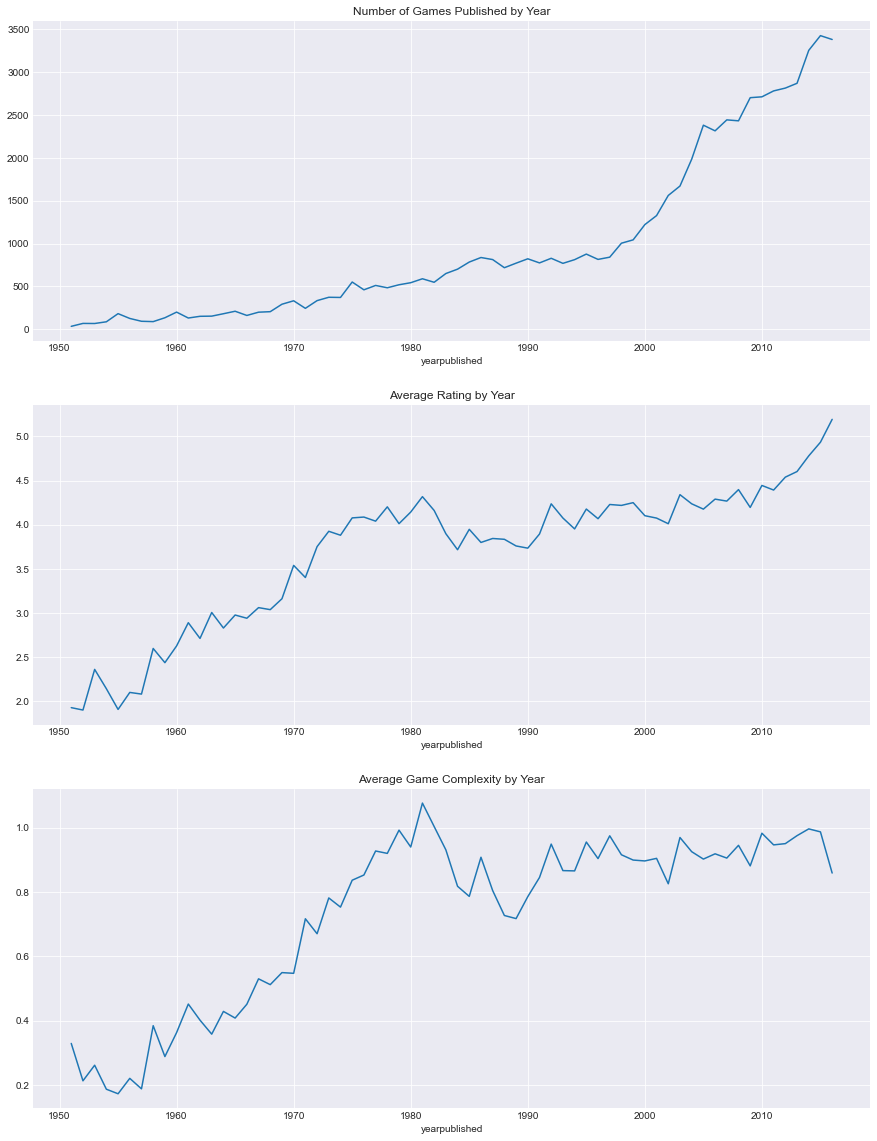

In [259]:
#as expected, board games boom in the recent decades, average ratings and complexities are also high
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
year_groups = data.groupby('yearpublished')
year_groups.size().plot(title='Number of Games Published by Year', ax=axes[0])
year_groups['average'].mean().plot( title='Average Rating by Year', ax=axes[1])
year_groups['averageweight'].mean().plot(title='Average Game Complexity by Year', ax=axes[2]);

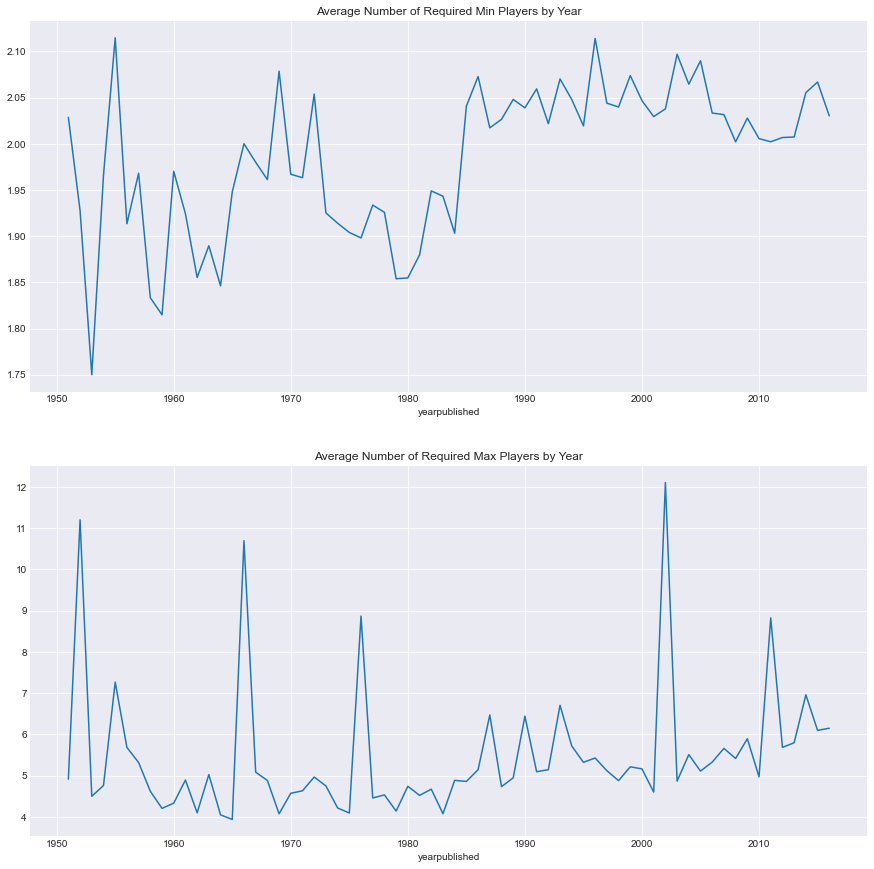

In [260]:
#it is interesting to see wether the dynamics of the average number of players changes throughout the years
#there are interesting spikes in the number of max players with visible periodicity
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
year_groups['minplayers'].mean().plot(title='Average Number of Required Min Players by Year', ax=axes[0])
year_groups['maxplayers'].mean().plot(title='Average Number of Required Max Players by Year', ax=axes[1]);

In [261]:
data['decades'] = pd.cut(data['yearpublished'], bins=7).map(lambda x: int(x.mid))

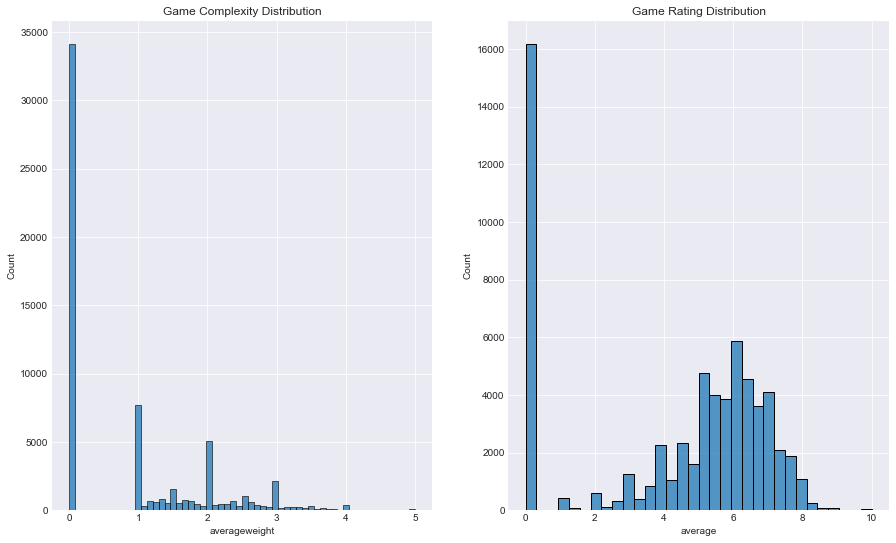

In [262]:
# there are many games that have low ratings and complexity, it can be due to the lack of information or just a big amount of garbage games
fig, axes = plt.subplots(1, 2, figsize=(15, 9))
sns.histplot(x=data['averageweight'], ax=axes[0])
axes[0].set_title('Game Complexity Distribution')
sns.histplot(x=data['average'], ax=axes[1])
axes[1].set_title('Game Rating Distribution');

Text(0.5, 0.98, 'Game rating vs complexity boxplot by decade')

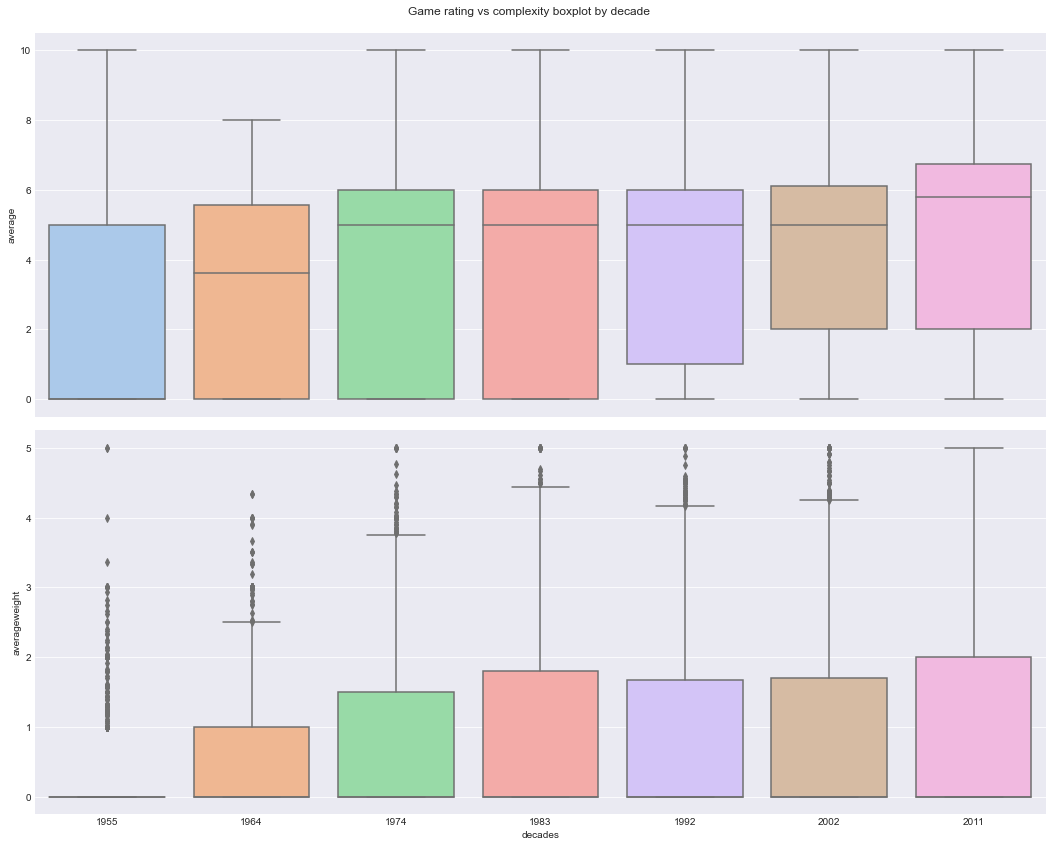

In [263]:
g = sns.PairGrid(data=data, x_vars=['decades'], y_vars=['average', 'averageweight'], height=6, aspect=2.5, palette='pastel')
g.map(sns.boxplot)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Game rating vs complexity boxplot by decade')

In [264]:
num_interest_cols = ['minplayers', 'maxplayers', 'average', 'averageweight']

<AxesSubplot:>

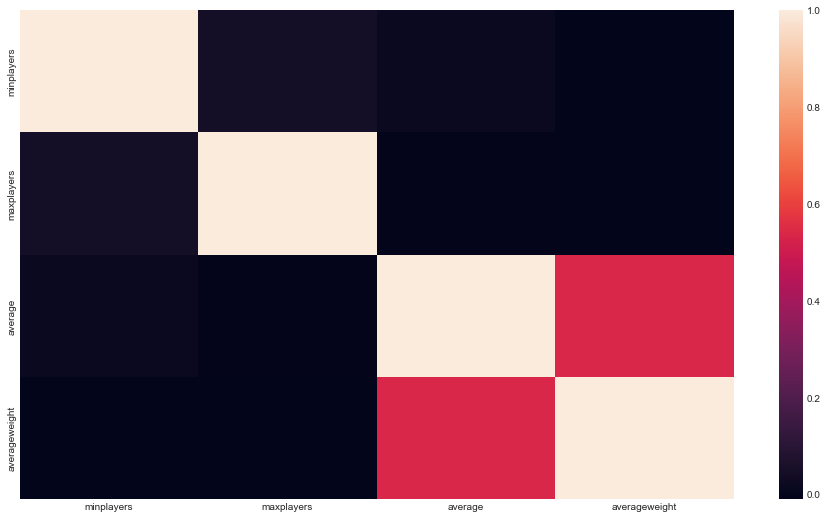

In [265]:
# there are no apparent correlations between the number of players and average rating/complextiy, however there is some relation between average ratings
#and game complexity, which is expected
plt.figure(figsize=(16, 9))
corr = data[num_interest_cols].corr()
sns.heatmap(corr)

In [266]:
#find categorical columns
#let's analyze board game categories
cols = data.columns
num_cols = data._get_numeric_data().columns
category = list(set(cols)-set(num_cols))
category_data = data.explode('category')

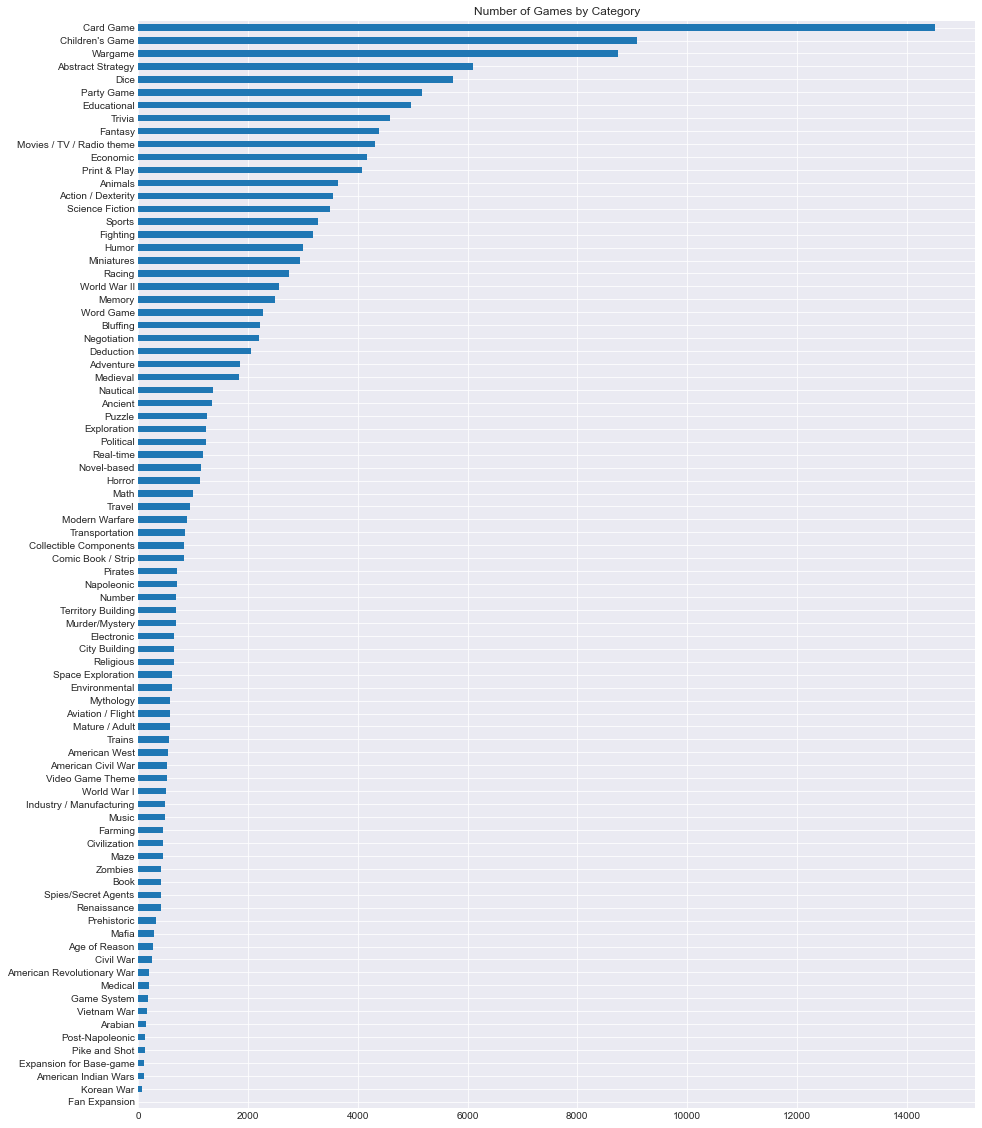

In [267]:
#the most popular category is card games, in the top 5 are wargames, strategy, dice also
category_values = category_data['category'].value_counts(ascending=False)
category_values[::-1].plot(kind='barh', title='Number of Games by Category', figsize=(15, 20));

In [268]:
#Let's have a peek at the top 10 catgories
top_10_cat = category_values.head(10)
top_10_data = category_data[category_data['category'].isin(top_10_cat.index)]

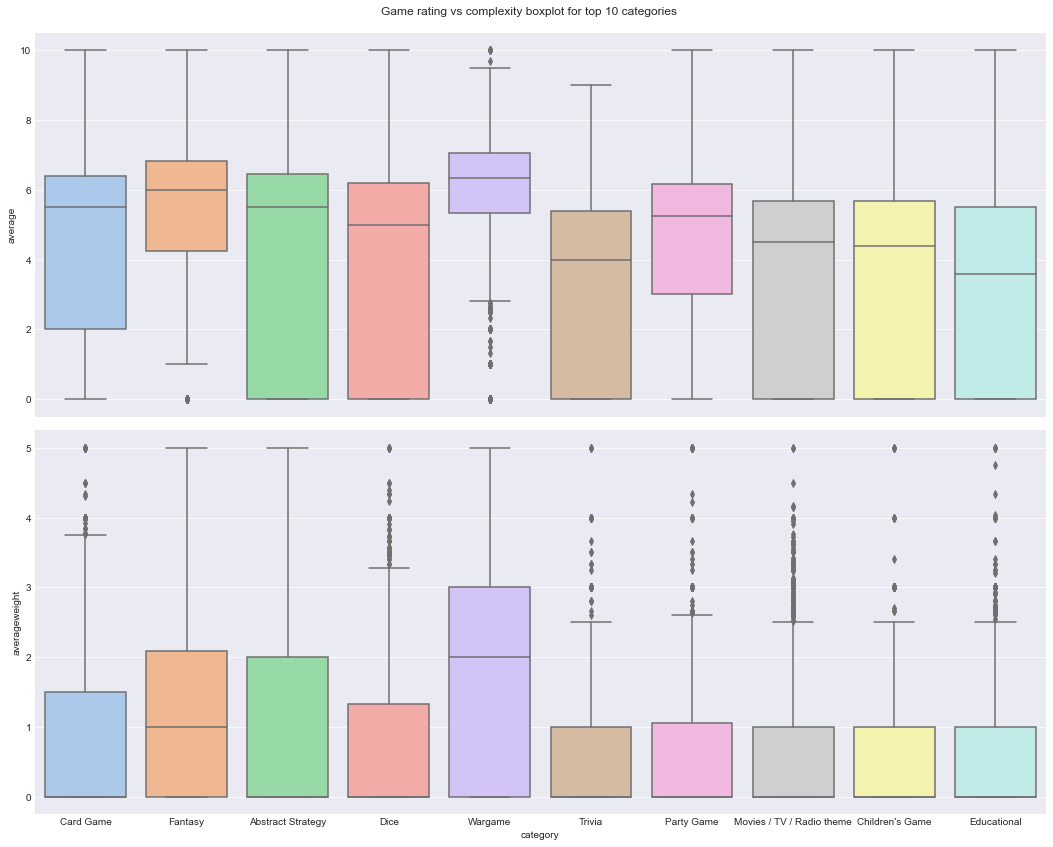

In [269]:
g = sns.PairGrid(data=top_10_data, x_vars=['category'], y_vars=['average', 'averageweight'], height=6, aspect=2.5, palette='pastel')
g.map(sns.boxplot)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Game rating vs complexity boxplot for top 10 categories');

In [270]:
year_cat_groups = top_10_data.groupby(['category', 'yearpublished']).size().unstack(0)
average_cat_groups = top_10_data.groupby(['category', 'yearpublished'])['average'].mean().unstack(0)
weight_cat_groups = top_10_data.groupby(['category', 'yearpublished'])['averageweight'].mean().unstack(0)

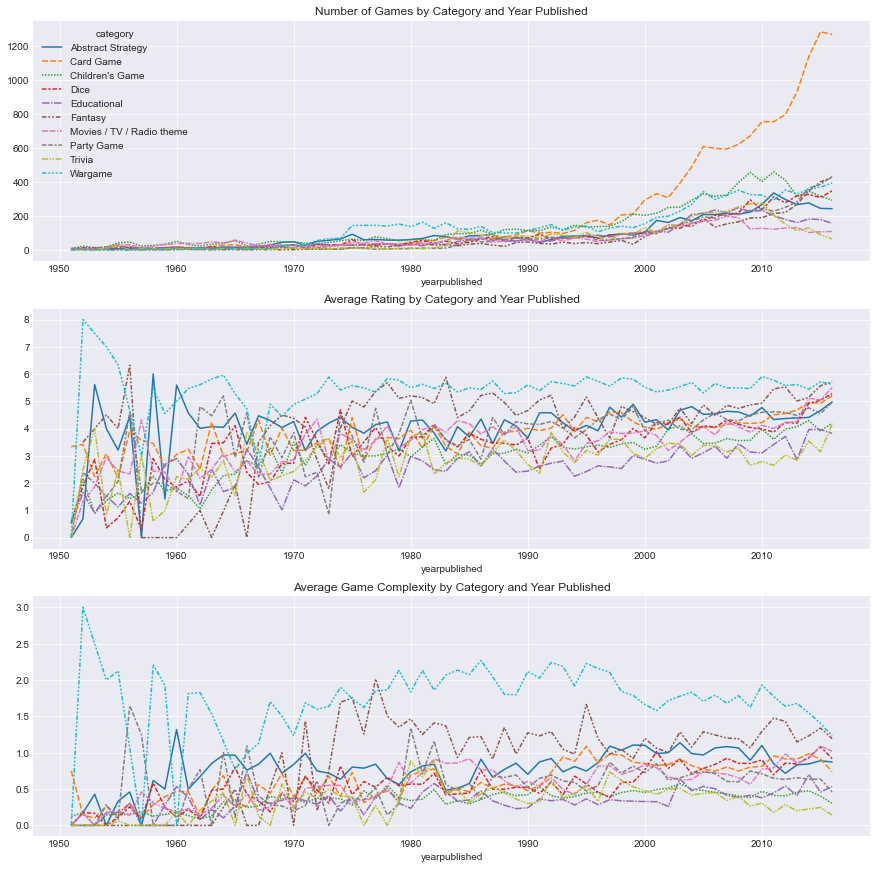

In [271]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.lineplot(data=year_cat_groups, ax=axes[0], legend=True)
sns.lineplot(data=average_cat_groups, ax=axes[1], legend=False)
sns.lineplot(data=weight_cat_groups, ax=axes[2], legend=False)
axes[0].set_title('Number of Games by Category and Year Published')
axes[1].set_title('Average Rating by Category and Year Published')
axes[2].set_title('Average Game Complexity by Category and Year Published');